In [7]:

!pip install torch torchvision numpy pandas matplotlib tqdm clip-by-openai
!pip install git+https://github.com/openai/CLIP.git
    

  Using cached clip_by_openai-1.1-py3-none-any.whl.metadata (369 bytes)
INFO: pip is looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
  Using cached clip_by_openai-1.0.1-py3-none-any.whl.metadata (407 bytes)
  Using cached clip_by_openai-0.1.1.5-py3-none-any.whl.metadata (8.6 kB)
  Using cached clip_by_openai-0.1.1.4-py3-none-any.whl.metadata (8.6 kB)
  Using cached clip_by_openai-0.1.1.3-py3-none-any.whl.metadata (8.7 kB)
  Using cached clip_by_openai-0.1.1.2-py3-none-any.whl.metadata (9.0 kB)
  Using cached clip_by_openai-0.1.1-py3-none-any.whl.metadata (9.0 kB)
  Using cached clip_by_openai-0.1.0-py3-none-any.whl.metadata (9.0 kB)
INFO: pip is still looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
  Using cached torchvision-0.21.0-cp310-cp310-win_amd64.whl.metadata (6.3 kB)
INFO: This is taking longer than u

ERROR: Cannot install clip-by-openai==0.1.0, clip-by-openai==0.1.1, clip-by-openai==0.1.1.2, clip-by-openai==0.1.1.3, clip-by-openai==0.1.1.4, clip-by-openai==0.1.1.5, clip-by-openai==1.0.1, clip-by-openai==1.1, torch and torchvision==0.12.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


  Cloning https://github.com/openai/CLIP.git to c:\users\arthu\appdata\local\temp\pip-req-build-_qbg__ji
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\arthu\AppData\Local\Temp\pip-req-build-_qbg__ji'


In [8]:

import torch
import clip
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from glob import glob
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import softmax
    

In [9]:
# load csv file and image paths to construct pokedex, use type_to_load=None to load all types, else use a list of types 1 to load
def construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/', type_to_load=None):
    pokedex = pd.read_csv(csv_path)
    image_paths = []

    for pokemon_name in pokedex["Name"]:
        imgs = glob(f"{image_dir}/{pokemon_name}/0.jpg")
        if len(imgs) > 0:
            image_paths.append(imgs[0])
        else:
            image_paths.append(None)

    pokedex["image_path"] = image_paths
    pokedex = pokedex[pokedex["image_path"].notna()].reset_index(drop=True)

    # only keep pokemon with distinct id
    ids, id_counts = np.unique(pokedex["ID"], return_counts=True)
    ids, id_counts = np.array(ids), np.array(id_counts)
    keep_ids = ids[id_counts == 1]

    pokedex = pokedex[pokedex["ID"].isin(keep_ids)].reset_index(drop=True)
    pokedex["Type2"] = pokedex["Type2"].str.strip()
    if type_to_load is not None:
        pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
    return pokedex

# load clip model
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

# inference clip model on a list of image path
def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():
        for img_path in tqdm(image_paths):
            img = Image.open(img_path)
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings += [image_embedding]
            
    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)
    return image_embeddings

# inference clip model on a list of texts
def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

# compute similarity of texts to each image
def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

# compute similarity of iamges to each text
def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

def compute_similarity(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

# Use TSNE to project CLIP embeddings to 2D space
def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    distance_matrix = np.zeros((image_embeddings.shape[0], image_embeddings.shape[0]))
    for i in range(image_embeddings.shape[0]):
        for j in range(image_embeddings.shape[0]):
            if i == j:
                distance_matrix[i, j] = 1
            else:
                distance_matrix[i, j] = np.dot(image_embeddings[i], image_embeddings[j])
    distance_matrix = 1 - distance_matrix
    reducer = TSNE(n_components=2, metric="precomputed", init="random", random_state=42)
    visualization_data = reducer.fit_transform(distance_matrix)
    return visualization_data

In [10]:
# Load data, model
pokedex = construct_pokedex()
clip_model, preprocess, device = load_clip_model()

# embedding
image_embeddings = clip_inference_image(clip_model, preprocess, pokedex['image_path'].tolist(), device)


100%|████████████████████████████████████████████████████████████████████████████████| 754/754 [06:22<00:00,  1.97it/s]


In [11]:
type_queries = ['type: Bug', 'type: Fire', 'type: Grass', 'type: Dark', 'type: Dragon']
text_embeddings = clip_inference_text(clip_model, preprocess, type_queries, device)


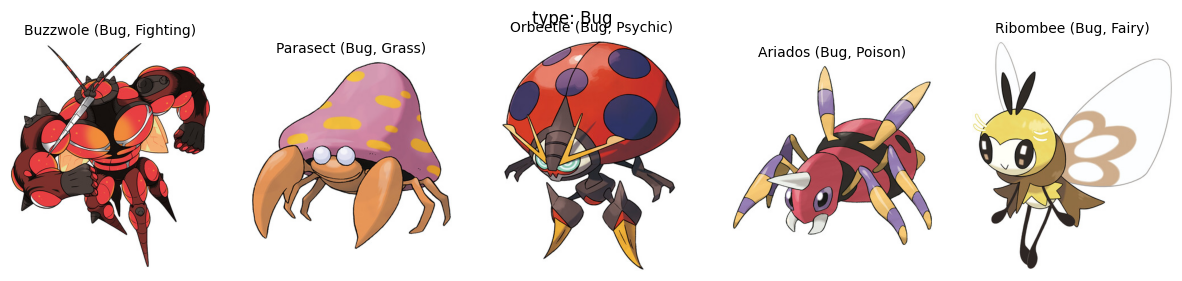

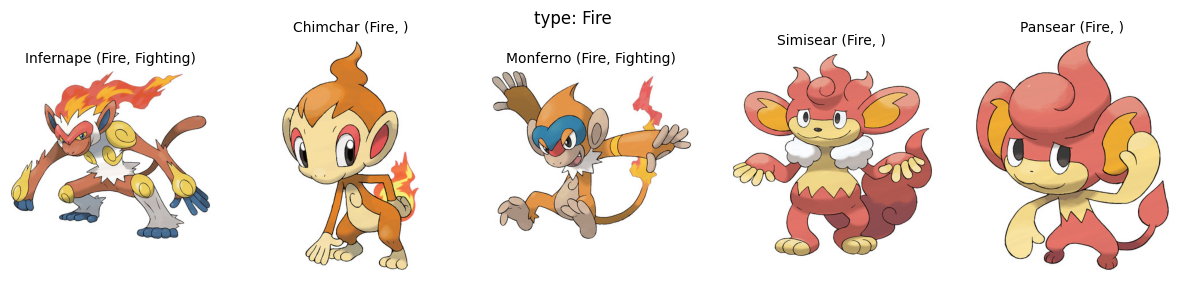

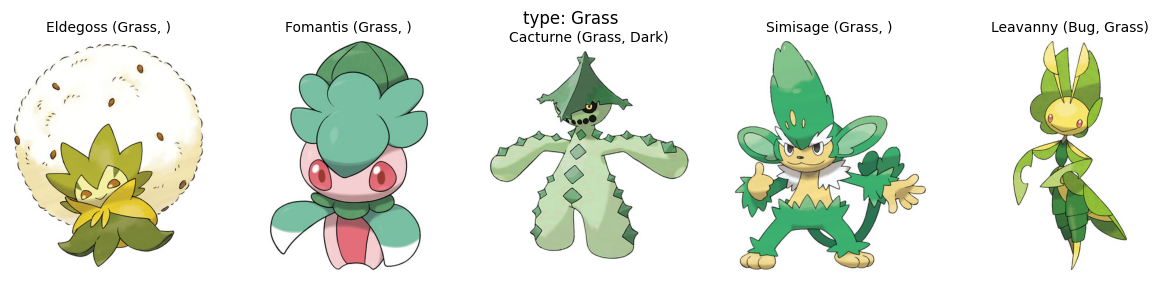

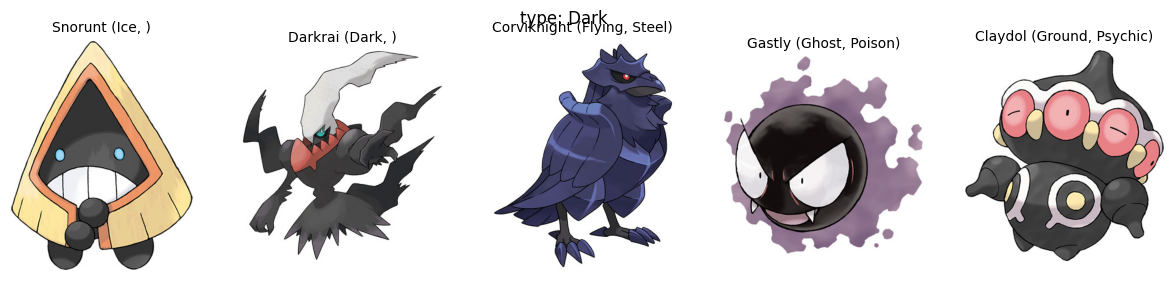

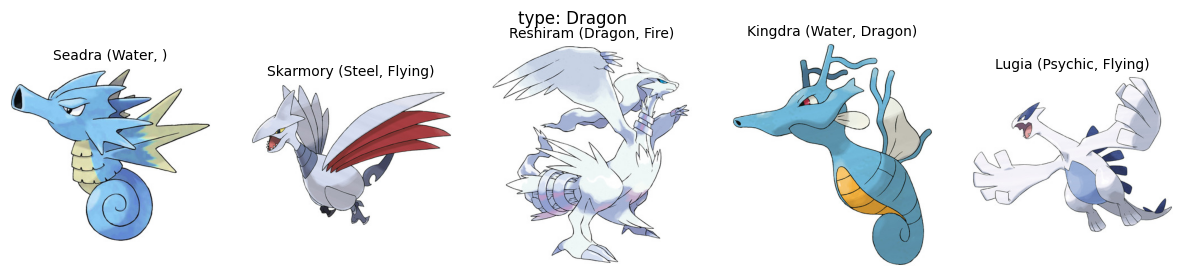

In [12]:
similarity_scores = compute_similarity(image_embeddings, text_embeddings)
top5_indices = np.argsort(-similarity_scores, axis=0)[:5]  # Negative sign for descending order

for query_index, query in enumerate(type_queries):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(query)

    for rank, ax in enumerate(axes):
        img_index = top5_indices[rank, query_index]
        image = Image.open(pokedex.loc[img_index, 'image_path'])
        
        ax.imshow(image)
        ax.axis('off')

        name = pokedex.loc[img_index, 'Name']
        type1 = pokedex.loc[img_index, 'Type1']
        type2 = pokedex.loc[img_index, 'Type2']
        
        title = f"{name} ({type1}" + (f", {type2})" if pd.notna(type2) else ")")
        ax.set_title(title, fontsize=10)

    plt.show()


QUESTION 27

In [13]:
# list of pokemon types
pokemon_types = ['Bug', 'Electric', 'Fire', 'Grass', 'Water', 'Dark', 'Dragon', 'Fairy', 'Ice', 'Psychic', 'Rock', 'Ground', 'Steel', 'Flying', 'Fighting', 'Normal', 'Poison', 'Ghost']
type_queries = [f"type: {ptype}" for ptype in pokemon_types]
text_embeddings = clip_inference_text(clip_model, preprocess, type_queries, device)

In [14]:
# Randomly select 10 Pokemon
selected_indices = np.random.choice(len(pokedex), 10, replace=False)
selected_pokemon = pokedex.iloc[selected_indices]
selected_image_embeddings = clip_inference_image(clip_model, preprocess, selected_pokemon['image_path'].tolist(), device)
similarity = compute_similarity(selected_image_embeddings, text_embeddings)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.98it/s]


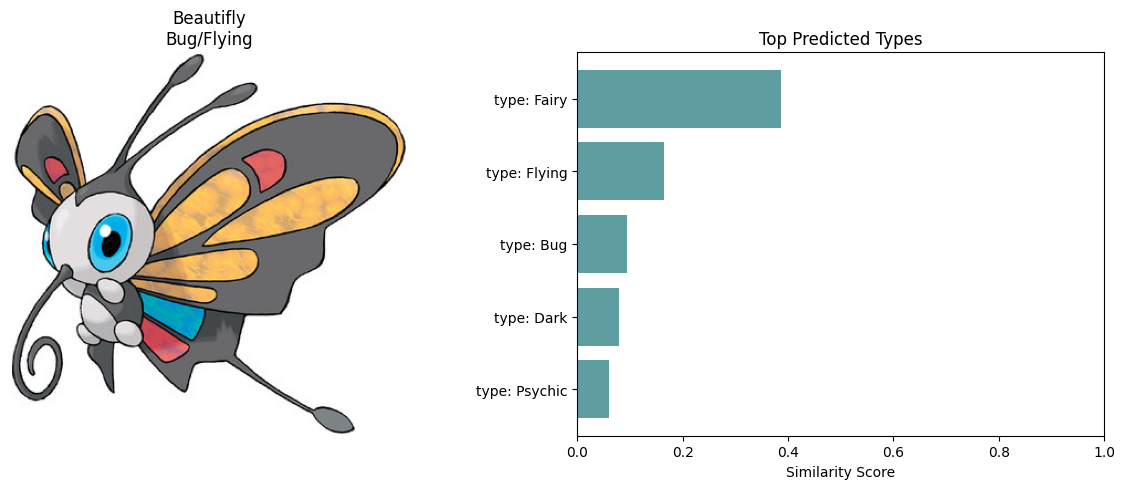

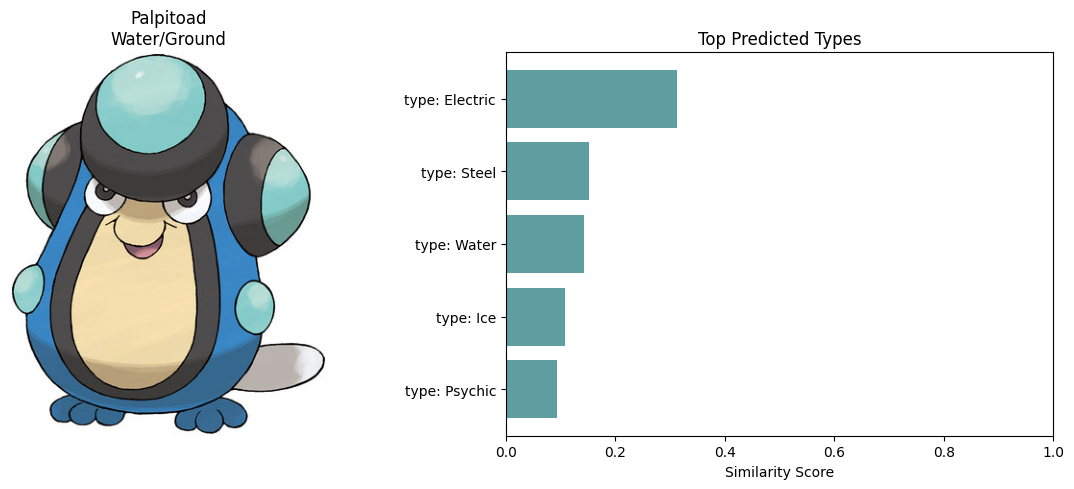

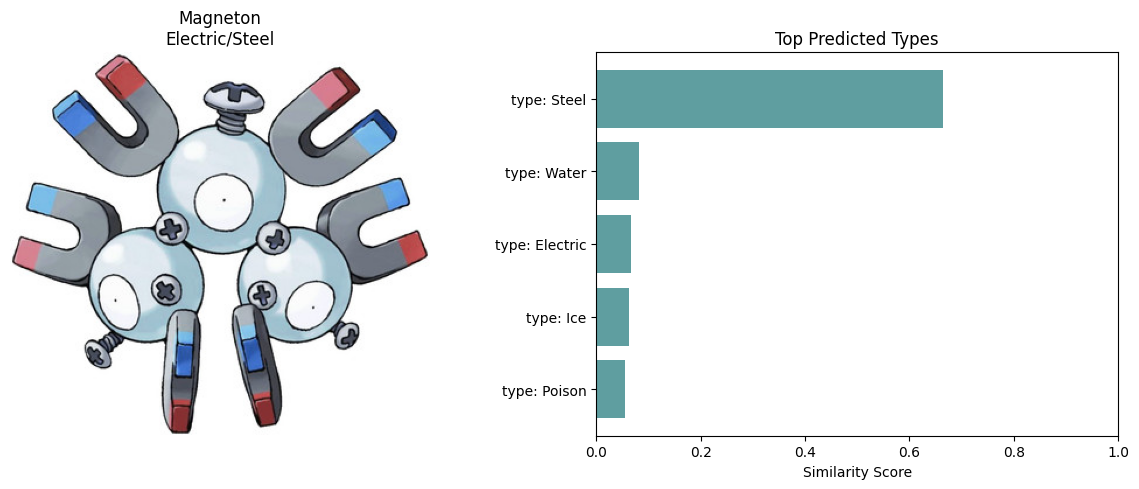

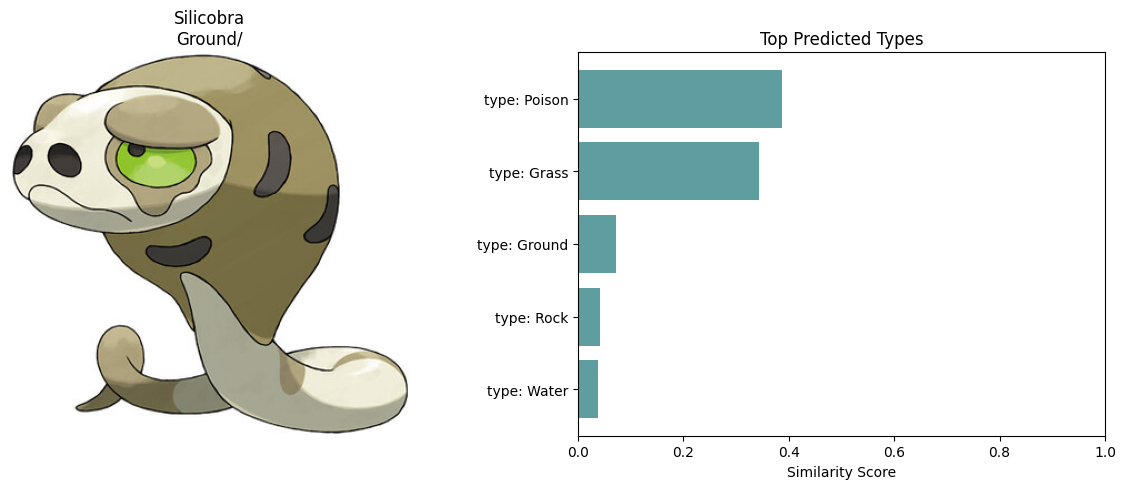

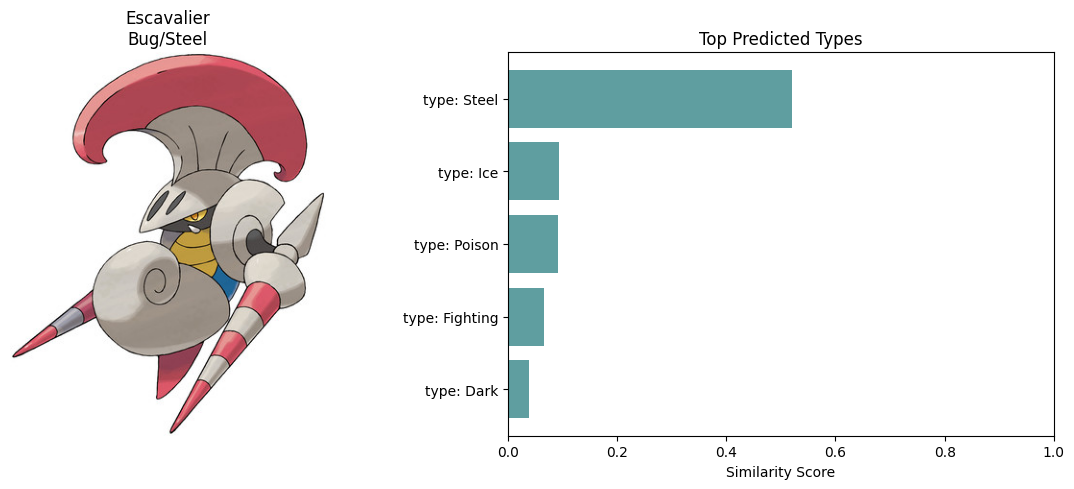

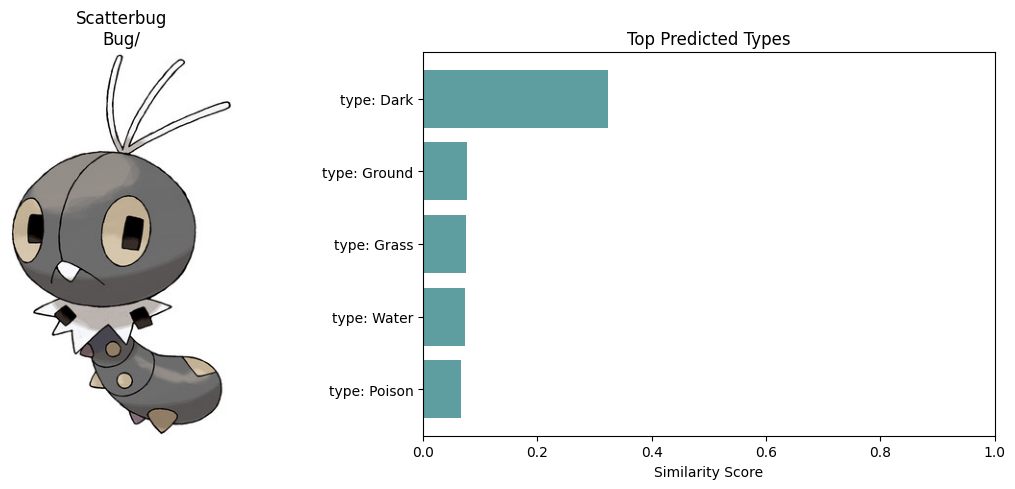

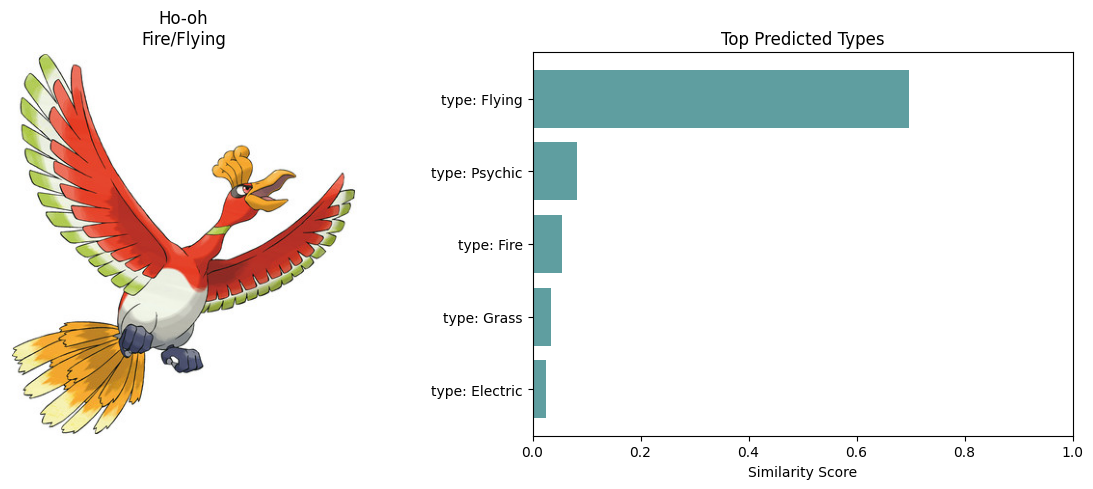

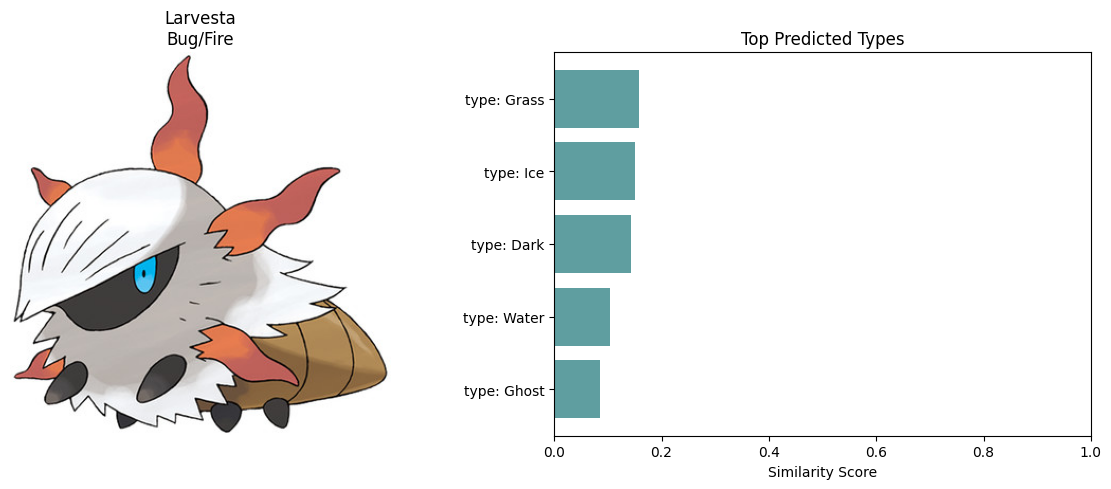

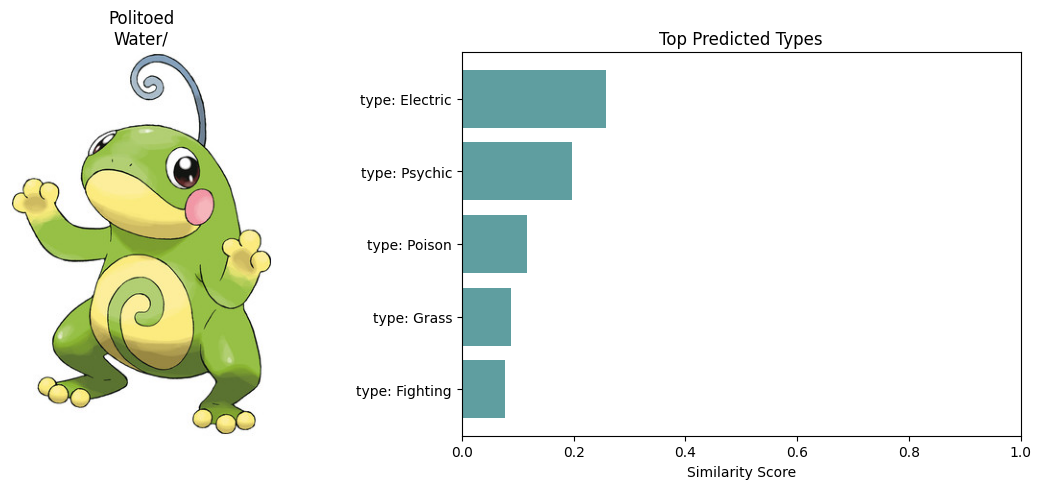

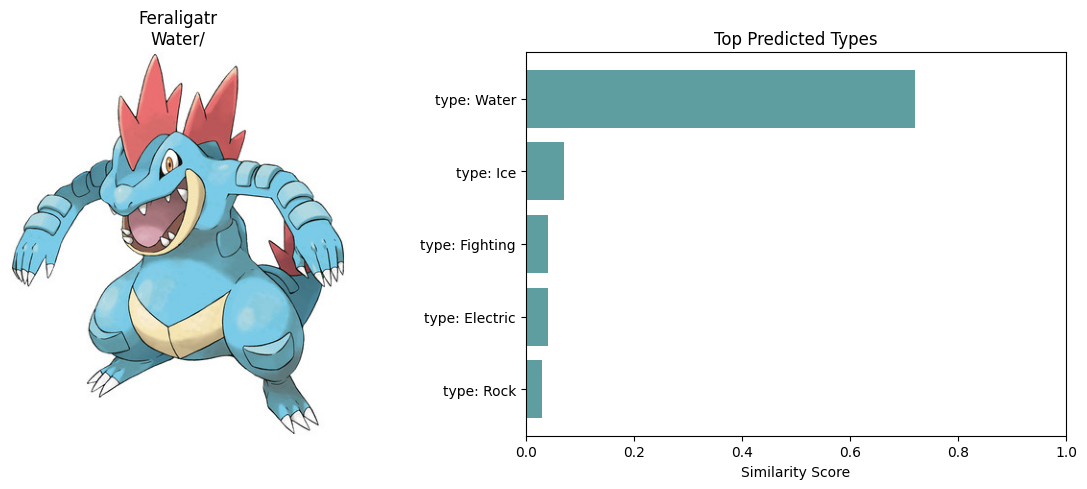

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

for i, idx in enumerate(selected_indices):
    # Prepare figure with two subplots (one for the image, one for the bar chart)
    fig, (ax_img, ax_bar) = plt.subplots(1, 2, figsize=(12, 5))
    
    # --- Show the Pokémon image in the left subplot ---
    img_path = pokedex.iloc[idx]['image_path']
    img = Image.open(img_path)
    ax_img.imshow(img)
    ax_img.axis('off')
    
    # Set a title that includes name and types
    name = pokedex.iloc[idx]['Name']
    type1 = pokedex.iloc[idx]['Type1']
    type2 = pokedex.iloc[idx]['Type2']
    ax_img.set_title(f"{name}\n{type1}/{type2}", fontsize=12)
    
    # --- Get top 5 predicted types ---
    # Sort similarity scores in descending order
    top_types_indices = np.argsort(similarity[i])[::-1][:5]
    top_types_scores = np.sort(similarity[i])[::-1][:5]
    
    # Retrieve the actual type labels for the top 5 predicted types
    top_types_labels = [type_queries[idx_] for idx_ in top_types_indices]
    
    # --- Plot the top 5 predicted types as a horizontal bar chart ---
    ax_bar.barh(top_types_labels, top_types_scores, color='cadetblue')
    ax_bar.invert_yaxis()  # So the highest score is on top
    ax_bar.set_xlim(0, 1)
    ax_bar.set_xlabel('Similarity Score')
    ax_bar.set_title('Top Predicted Types', fontsize=12)
    
    # Adjust spacing and show
    plt.tight_layout()
    plt.show()


QUESTION 28

In [16]:
selected_types = ['Bug', 'Fire', 'Grass']
selected_pokemon = pokedex[pokedex['Type1'].isin(selected_types)]
selected_image_embeddings = clip_inference_image(clip_model, preprocess, selected_pokemon['image_path'].tolist(), device)

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(selected_image_embeddings)

df_tsne = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
df_tsne['Name'] = selected_pokemon['Name'].values
df_tsne['Type1'] = selected_pokemon['Type1'].values
df_tsne['Type2'] = selected_pokemon['Type2'].fillna('').values
df_tsne['Label'] = df_tsne['Name'] + ' (' + df_tsne['Type1'] + '/' + df_tsne['Type2'] + ')'

fig = px.scatter(df_tsne, x='tsne1', y='tsne2', color='Type1', hover_name='Label')
fig.update_traces(marker=dict(size=12, opacity=0.8, line=dict(width=2, color='DarkSlateGrey')))
fig.update_layout(title='t-SNE visualization of Pokémon Types (Bug, Fire, Grass)', xaxis_title='TSNE 1', yaxis_title='TSNE 2')
fig.show()


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [01:36<00:00,  2.00it/s]


NameError: name 'TSNE' is not defined